In [1]:
# !wget https://raw.githubusercontent.com/Hari31416/Identify_Contrails/main/codes/metadata.csv

# imports

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import pandas as pd
import os
from argparse import Namespace

In [3]:
# Set the GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# config

In [4]:
if os.environ.get("KAGGLE_KERNEL_RUN_TYPE", ""):
    BASE_DIR = '/kaggle/input/google-research-identify-contrails-reduce-global-warming'
else:
    BASE_DIR =  'data'

In [5]:
configs = Namespace(
        BASE_DIR= BASE_DIR,
        BATCH_SIZE= 64,
        LR= 1e-4,
        EPOCHS= 10,
        IMG_SIZE= 256,
        THRESHOLD= 0.4
)

# load data

In [6]:
df_train_idx = pd.DataFrame({'idx': os.listdir(f'{configs.BASE_DIR}/train')})
df_validation_idx = pd.DataFrame({'idx': os.listdir(f'{configs.BASE_DIR}/validation')})

In [7]:
# os.listdir(f'{configs.BASE_DIR}/validation')

In [8]:
df_validation_idx.head()

,idx
0,3687499407028137410
1,6558861185867890815
2,7355354609194882312
3,7547747455642200110
4,5456834089979970017


In [9]:
df_train_idx.shape

(20529, 1)

In [10]:
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)
N_TIMES_BEFORE = 4


def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

def load_one_record(record_id, BASE_DIR,train=True):
    band11 = np.load(f"{BASE_DIR}/{str(record_id)}/band_11.npy")
    band14 = np.load(f"{BASE_DIR}/{str(record_id)}/band_14.npy")
    band15 = np.load(f"{BASE_DIR}/{str(record_id)}/band_15.npy")
        
    r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(band14, _T11_BOUNDS)
    false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
    
    img = false_color[..., N_TIMES_BEFORE]

    if not train:
        return img

    human_pixel_mask =  np.load(f"{BASE_DIR}/{str(record_id)}/human_pixel_masks.npy")
    
    return img, human_pixel_mask

def train_loader_function():
    for i in range(df_train_idx.shape[0]):
        row = df_train_idx.iloc[i]
        record_id = row["idx"]
        img, mask = load_one_record(record_id, f"{configs.BASE_DIR}/train")
        yield img, mask
        
def validation_loader_function():
    for i in range(df_validation_idx.shape[0]):
        row = df_validation_idx.iloc[i]
        record_id = row["idx"]
        img, mask = load_one_record(record_id, f"{configs.BASE_DIR}/validation")
        yield img, mask



train_dataloader = tf.data.Dataset.from_generator(train_loader_function, (tf.float32, tf.float32), output_shapes=([configs.IMG_SIZE,configs.IMG_SIZE,3], [configs.IMG_SIZE, configs.IMG_SIZE, 1]))
validation_dataloader = tf.data.Dataset.from_generator(validation_loader_function, (tf.float32, tf.float32), output_shapes=([configs.IMG_SIZE,configs.IMG_SIZE,3], [configs.IMG_SIZE, configs.IMG_SIZE, 1]))
train_dataset = train_dataloader.prefetch(tf.data.AUTOTUNE).batch(configs.BATCH_SIZE).repeat()
validation_dataset = validation_dataloader.prefetch(tf.data.AUTOTUNE).batch(configs.BATCH_SIZE).repeat()

In [11]:
for i in train_dataset:
    print(i[0].shape)
    print(i[1].shape)
    break

(64, 256, 256, 3)
(64, 256, 256, 1)


# model

## U-Net

In [12]:
# define U-Net model
import tensorflow as tf

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU

def create_mask(image, threshold):
    mask = tf.math.greater(image, threshold)
    return tf.cast(mask, tf.float32)

def iou_coef(y_true, y_pred, smooth=1):

    y_pred = create_mask(y_pred, 0.5)
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_coef_loss(y_true, y_pred):

    y_pred = create_mask(y_pred, configs.THRESHOLD)

    batch_size = K.cast(K.shape(y_true)[0], dtype=tf.float32)

    bce_loss = BinaryCrossentropy()(y_true, y_pred)
    iou_loss = 1 - iou_coef(y_true, y_pred)


    return (bce_loss + iou_loss)

def dice_coef(y_true, y_pred, smooth=1):

    y_pred = create_mask(y_pred, 0.5)
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    # union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    union = K.sum(y_true + y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_coef_loss(y_true, y_pred):

    y_pred = create_mask(y_pred, 0.5)
    batch_size = K.cast(K.shape(y_true)[0], dtype=tf.float32)
    bce_loss = BinaryCrossentropy()(y_true, y_pred)
    dice_loss = 1 - dice_coef(y_true, y_pred)

    return (bce_loss + dice_loss)


class UNet:

    def __init__(self, input_shape):
        self.input_shape = input_shape

    def _conv_block(self, input_tensor, n_filters, kernel_size=3):
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding="same")(input_tensor)
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding="same")(x)
        return x

    def resnet_encoder(self, input_tensor, filters):
        skip= self._conv_block(input_tensor, filters)
        x = MaxPooling2D((2, 2))(skip)

        return x, skip
    
    def resnet_decoder(self, input_tensor, skip_tensor, filters):
        x = Conv2DTranspose(filters=filters, kernel_size=(3, 3), strides=(2, 2), padding="same")(input_tensor)
        x = concatenate([x, skip_tensor])
        x = self._conv_block(x, filters)
        return x
    
    def bottleneck(self, input_tensor, filters):
        x = self._conv_block(input_tensor, filters)
        return x
    
    def lstm_layer(self, input_tensor, filters):
        x = tf.keras.layers.ConvLSTM2D(filters=filters, kernel_size=(3, 3), padding="same", return_sequences=False, data_format="channels_last")(input_tensor)
        return x



    def build(self):

        # input_band11_ = Input(shape=self.input_shape)    # (256,256,8) (height, width, time_steps)
        # input_band14_ = Input(shape=self.input_shape)    # (256,256,8) (height, width, time_steps)
        # input_band15_ = Input(shape=self.input_shape)    # (256,256,8) (height, width, time_steps)

        # # permutate the input_band11 to (time_steps, height, width, channels)
        # input_band11 = tf.keras.layers.Permute((3,1,2))(input_band11_) # (8, 256, 256)
        # input_band14 = tf.keras.layers.Permute((3,1,2))(input_band14_)
        # input_band15 = tf.keras.layers.Permute((3,1,2))(input_band15_)

        # # unsqueeze the input_band11 to (time_steps, height, width, channels)
        # input_band11 = tf.expand_dims(input_band11, axis=4)  # (8, 256, 256, 1)
        # input_band14 = tf.expand_dims(input_band14, axis=4)
        # input_band15 = tf.expand_dims(input_band15, axis=4)

        
        # # make a LSTM layer for each band
        # x_band11 = self.lstm_layer(input_band11, 4) # (256, 256, 4)
        # x_band14 = self.lstm_layer(input_band14, 4)
        # x_band15 = self.lstm_layer(input_band15, 4)

        # # concatenate the bands
        # x = concatenate([x_band11, x_band14, x_band15]) # (256, 256, 12)
        
        input = Input(shape=self.input_shape)

        x = input


        # Encoder
        x, skip0 = self.resnet_encoder(x, 32)

        x, skip1 = self.resnet_encoder(x, 64)
        x = tf.keras.layers.BatchNormalization()(x)

        x, skip2 = self.resnet_encoder(x, 128)

        x, skip3 = self.resnet_encoder(x, 256)
        x = tf.keras.layers.BatchNormalization()(x)
        x = Dropout(0.3)(x)

        x, skip4 = self.resnet_encoder(x, 512)

        # Bottleneck
        x = self.bottleneck(x, 512)

        # Decoder
        x = self.resnet_decoder(x, skip4, 512)
        
        
        x = self.resnet_decoder(x, skip3, 256)
        x = tf.keras.layers.BatchNormalization()(x)
        x = Dropout(0.3)(x)
        
        x = self.resnet_decoder(x, skip2, 128)

        x = self.resnet_decoder(x, skip1, 64)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = self.resnet_decoder(x, skip0, 32)

        # Output
        output_tensor = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(x)

        model = Model([input], output_tensor)
        return model

    # add dice_coef to loss
    # def compile(self, optimizer, loss, metrics):
    #     super().compile(
    #         optimizer=optimizer
    #     )

# create model

model = UNet((256, 256, 3)).build()

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryFocalCrossentropy(),
    metrics=[dice_coef]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [13]:
callbacks = [
    EarlyStopping(patience=1, verbose=1, restore_best_weights=True, monitor='dice_coef', mode='max'),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('callbacks/model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

train_steps = df_train_idx.shape[0]//configs.BATCH_SIZE
validation_steps = df_validation_idx.shape[0]//configs.BATCH_SIZE

# train_steps = 20
# validation_steps = 20

# history = model.fit(train_dataset, epochs=1, verbose=1, validation_data=validation_dataset,  callbacks=callbacks, steps_per_epoch=train_steps, validation_steps=validation_steps)

history = model.fit(train_dataset, epochs=5, verbose=1, callbacks=callbacks, steps_per_epoch=train_steps, shuffle=True)

Epoch 1/5


2023-07-18 09:35:46.241524: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


320/320 [==============================] - 1898s 6s/step - loss: 0.0120 - dice_coef: 0.4978 - lr: 0.0010
Epoch 2/5
320/320 [==============================] - 1585s 5s/step - loss: 0.0081 - dice_coef: 0.4266 - lr: 0.0010
Epoch 2: early stopping


# save the model

In [14]:
model.evaluate(validation_dataset, steps=validation_steps)

29/29 [==============================] - 172s 5s/step - loss: 0.0050 - dice_coef: 0.7018


[0.00501864030957222, 0.7018380165100098]

In [15]:
model.save('model.h5')

In [16]:
df_validation_idx.tail()

,idx
1851,922629314296188212
1852,3319793057592206418
1853,5640456394563366318
1854,6742201885695641013
1855,8195127976521848310


1/1 [==============================] - 1s 885ms/step


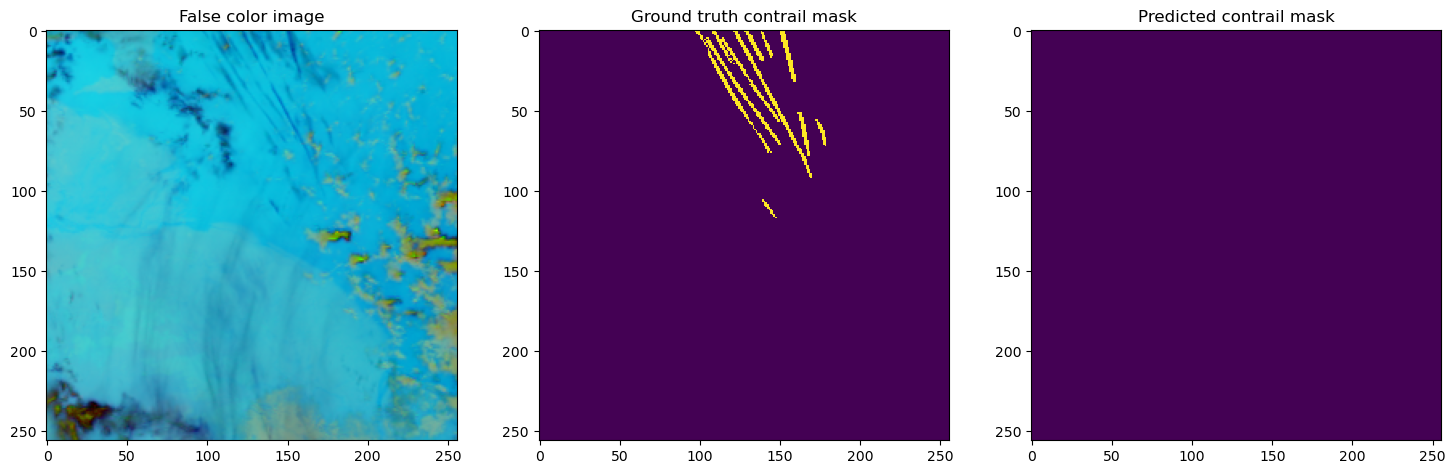

In [17]:
def plot_validation_image(indx):
    val_img, val_mask = load_one_record(df_validation_idx.iloc[indx]["idx"], f"{configs.BASE_DIR}/validation", train=True)
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 3, 1)
    ax.imshow(val_img)
    ax.set_title('False color image')

    ax = plt.subplot(1, 3, 2)
    ax.imshow(val_mask, interpolation='none')
    ax.set_title('Ground truth contrail mask')



    pred = model.predict(val_img.reshape(1, 256, 256, 3))
#     pred_mask = create_mask(pred, configs.THRESHOLD)
    pred_mask = create_mask(pred, 0.4)
    pred_mask = pred_mask[0, :, :, 0]

    ax = plt.subplot(1, 3, 3)
    ax.imshow(pred_mask, interpolation='none')
    ax.set_title('Predicted contrail mask')


plot_validation_image(5)
# plot_validation_image(105)

# test

# rle encoding

In [18]:
#source https://www.kaggle.com/code/inversion/contrails-rle-submission?scriptVersionId=128527711&cellId=4

def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s


In [19]:
df_test_idx = pd.DataFrame({'idx': os.listdir(f'{configs.BASE_DIR}/test')})

def test_loader_function():
    for i in range(df_test_idx.shape[0]):
        row = df_test_idx.iloc[i]
        record_id = row["idx"]
        img = load_one_record(record_id, f"{configs.BASE_DIR}/test", train=False)
        yield img

test_dataloader = tf.data.Dataset.from_generator(test_loader_function, tf.float32, output_shapes=([configs.IMG_SIZE, configs.IMG_SIZE, 3]))
test_dataset = test_dataloader.prefetch(tf.data.AUTOTUNE).batch(configs.BATCH_SIZE)

In [20]:
predictions = model.predict(test_dataset, verbose=0)

In [21]:
# Create an empty DataFrame for submission
submission_df = pd.DataFrame(columns=['encoded_pixels'])
submission_df.index.name = 'record_id'

In [22]:
masked_predictions = create_mask(predictions,configs.THRESHOLD)
masked_predictions_ = np.array(masked_predictions)


for i in range(predictions.shape[0]):
    submission_df.loc[df_test_idx.iloc[i]['idx'], "encoded_pixels"] = list_to_string(rle_encode(masked_predictions_[i]))

In [23]:
submission_df.head()

,encoded_pixels
record_id,
1002653297254493116,-
1000834164244036115,-


In [24]:
submission_df.to_csv("submission.csv")